In [1]:
#Import modules
import numpy as np
from surprise import SVD
from surprise.model_selection import cross_validate
from surprise import Dataset
import pandas as pd
from surprise import Reader
from surprise.model_selection.split import PredefinedKFold
from surprise import accuracy
from surprise.prediction_algorithms.knns import KNNBasic
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Load Data
folds_files = [('train.txt','test.txt')]
reader = Reader(line_format='user item rating', sep='\t', skip_lines=None, rating_scale=(1, 5))
data = Dataset.load_from_folds(folds_files,reader=reader)
pkf = PredefinedKFold()
trainset, testset = next(pkf.split(data))

In [4]:
#Set params
k=20
epochs = 30
lambdas = 0.1
eta = 0.03
#Run biased model
algo = SVD(n_factors=k,n_epochs=epochs,reg_all=0.1,lr_all=eta)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions,verbose=True)

#Set params
k=20
epochs = 30
lambdas = 0.1
#Run unbiased model
algo = SVD(n_factors=k,n_epochs=epochs,biased=False,reg_all=0.1,lr_all=eta)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions,verbose=True)


RMSE: 0.9125
RMSE: 0.9468


0.9468438663284815

In [5]:
#Now fit the model on the whole data set
#Load Data
reader = Reader(line_format='user item rating', sep='\t', skip_lines=None, rating_scale=(1, 5))
data = Dataset.load_from_file('data.txt',reader=reader)
trainset = data.build_full_trainset()
#Set params
k=20
epochs = 30
lambdas = 0.1
eta = 0.03
#fit movie lens data set
algo = SVD(n_factors=k,n_epochs=epochs,biased=False,reg_all=0.1,lr_all=eta)
algo.fit(trainset)
#Get V and U
V_surprise = algo.qi
U_surprise = algo.pu

In [7]:
#Earlier script that returns IDs for most popular movies and best movies
import numpy as np
import matplotlib.pyplot as plt

#Problem 1
data = np.loadtxt('data.txt',delimiter='\t')
MovieNames = np.genfromtxt('movies.txt',delimiter='\t',dtype=None,encoding='ISO-8859-1',usecols=(1,))

User_ID = data[:,0]
Movie_ID = data[:,1]
Rating = data[:,2]

labels, counts = np.unique(Rating, return_counts=True)

#Problem 2
Movie_ID_number, counts_Movie_ID = np.unique(Movie_ID, return_counts=True)
counts_Movie_ID, Movie_ID_number = zip(*sorted(zip(counts_Movie_ID,Movie_ID_number)))
Most_popular_movie_ID = Movie_ID_number[len(Movie_ID_number)-11:len(Movie_ID_number)-1]
Most_popular_movie_counts = counts_Movie_ID[len(counts_Movie_ID)-11:len(counts_Movie_ID)-1]
Most_popular_movie_name = []
for ID in Most_popular_movie_ID:
    Most_popular_movie_name.append(MovieNames[int(ID)-1])

#Problem 3
Average_rating = []
for ID in Movie_ID_number:
    summing = 0
    division = 0
    for i in range(len(Movie_ID)):
        if Movie_ID[i] == ID:
            summing += Rating[i]
            division += 1
    Average_rating.append(summing/division)
        
Average_rating, Movie_ID_number = zip(*sorted(zip(Average_rating,Movie_ID_number)))

Best_movie_ID = Movie_ID_number[len(Movie_ID_number)-11:len(Movie_ID_number)-1]
Best_movie_rating = Average_rating[len(Average_rating)-11:len(Average_rating)-1]
Best_movie_name = []
for ID in Best_movie_ID:
    Best_movie_name.append(MovieNames[int(ID)-1])

Average_rating_of_popular_movies = []

for ID in Most_popular_movie_ID:
    for index in range(len(Movie_ID_number)):
        if Movie_ID_number[index] == ID:
           Average_rating_of_popular_movies.append(Average_rating[index])

In [9]:
#Plot random 10 movies
Movie_ID = np.array([127,187,64,172,181,50,59,60,61,89]) #array of 10 random movies IDs
#Names of 10 random movies
Movie_name = ['Godfather Part I','Godfather: Part II','Shawshank Redemption','Empire Strikes Back','Return of the Jedi','Star Wars','Three Colors: Red','Three Colors:Blue','Three Colors: White','Blade Runner']

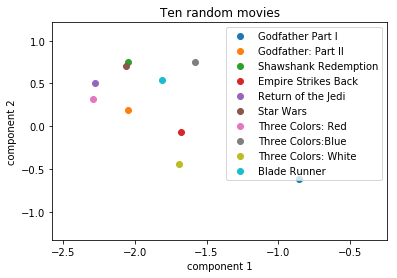

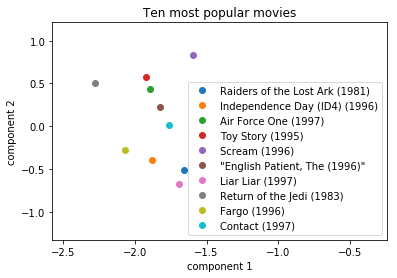

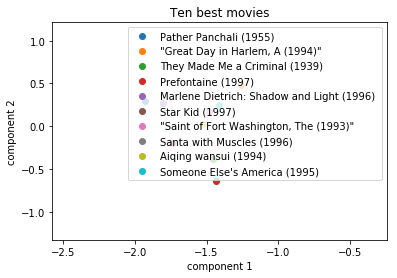

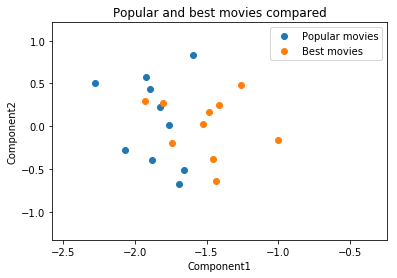

In [11]:
def project_movies_2D(V, movie_IDs):
    V_T = np.transpose(V)
    A_v, sigma_v, B_v = np.linalg.svd(V_T)

    # 2D projection of U and V
    # U_proj = np.matmul(A_u[:,0:2], U)
    V_proj = np.matmul(np.transpose(A_v[:, 0:2]), V_T)

    # take only the columns corresponding to movie ids. 
    # movie ids are 1 indexed, so subtract by 1. 
    zero_index_movie_IDs = movie_IDs - 1
    V_proj_specific = V_proj[:, zero_index_movie_IDs]

    return (V_proj_specific[0], V_proj_specific[1])

def project_movies_2D_all(V):
    V_T = np.transpose(V)
    A_v, sigma_v, B_v = np.linalg.svd(V_T)

    # 2D projection of U and V
    # U_proj = np.matmul(A_u[:,0:2], U)
    V_proj = np.matmul(np.transpose(A_v[:, 0:2]), V_T)

    return (V_proj[0], V_proj[1])

V1_all,V2_all = project_movies_2D_all(V_surprise)

#Get components for ten random movies 
V11,V21 = project_movies_2D(V_surprise, Movie_ID)

#Plot ten random movies
plt.figure(1)
for i in range(len(V11)):
    plt.plot(V11[i],V21[i],'o',label=Movie_name[i])
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.xlim(min(V1_all),max(V1_all))
plt.ylim(min(V2_all),max(V2_all))
plt.title('Ten random movies')
plt.legend()

#Ten most popular movies
Most_popular_movie_ID_ints = []
for i in Most_popular_movie_ID:
    Most_popular_movie_ID_ints.append(int(i))
Most_popular_movie_ID_ints = np.array(Most_popular_movie_ID_ints)
    
#Get components for ten most popular movies
V12,V22 = project_movies_2D(V_surprise,Most_popular_movie_ID_ints)
#Plot 10 most popular movies
plt.figure(2)
for i in range(len(V12)):
    plt.plot(V12[i],V22[i],'o',label=Most_popular_movie_name[i])
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.xlim(min(V1_all),max(V1_all))
plt.ylim(min(V2_all),max(V2_all))
plt.title('Ten most popular movies')
plt.legend()

#Ten best movies
Best_movie_ID_ints = []
for i in Best_movie_ID:
    Best_movie_ID_ints.append(int(i))

#Get components for 10 best movies
V13,V23 = project_movies_2D(V_surprise,np.array(Best_movie_ID_ints))
#Plot 10 best movies
plt.figure(3)
for i in range(len(V13)):
    plt.plot(V13[i],V23[i],'o',label=Best_movie_name[i])
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.xlim(min(V1_all),max(V1_all))
plt.ylim(min(V2_all),max(V2_all))
plt.title('Ten best movies')
plt.legend()

plt.figure(4)
plt.plot(V12,V22,'o',label='Popular movies')
plt.plot(V13,V23,'o',label='Best movies')
plt.legend(loc='best')
plt.xlabel('Component1')
plt.ylabel('Component2')
plt.title('Popular and best movies compared')
plt.xlim(min(V1_all),max(V1_all))
plt.ylim(min(V2_all),max(V2_all))



plt.show()

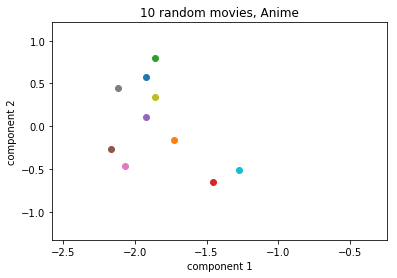

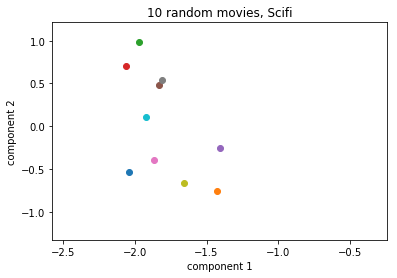

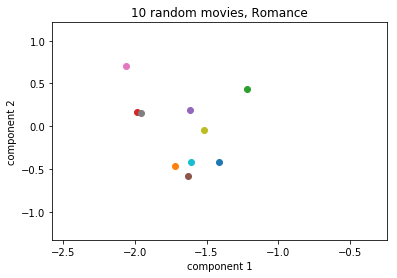

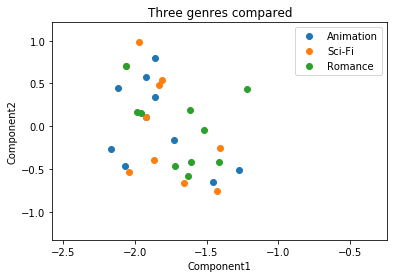

In [13]:
#IDs and names of 10 random movies from Animation, Sci-Fi and Romance genres
Anime_ID = np.array([1,71,95,99,101,102,103,2,114,169])
Anime_names = ['Toy Story','Lion King','Aladdin','Snow White','Heavy Metal','Aristocats','All Dogs Go to Heaven 2','Wallace and Gromit','Wrong Trouser','Grand Day Out, A']
Scifi_ID = np.array([7,38,39,50,62,82,84,89,96,101])
Scifi_names = ['Twelve Monkeys','The Net','Strange Days','Star Wars','Stargate','Jurassic Park','Robert A Heinleins The Puppet Masters','Blade Runner','Terminator 2','Heavy Metal']
Romance_ID = np.array([14,16,20,33,36,49,50,51,55,66])
Romance_names = ['Postino, II','French Twist','Angels and Insects','Desperado','Mad Love','I.Q.','Star Wars','Legends of the Fall','Professional, The','While You Were Sleeping']

#Plot Animation movies
V11,V21 = project_movies_2D(V_surprise, Anime_ID)
plt.figure(1)
for i in range(len(V11)):
    plt.plot(V11[i],V21[i],'o',label=Anime_names[i])
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.xlim(min(V1_all),max(V1_all))
plt.ylim(min(V2_all),max(V2_all))
plt.title('10 random movies, Anime')
#plt.legend()

#Plot Sci-Fi movies
V12,V22 = project_movies_2D(V_surprise, Scifi_ID)
plt.figure(2)
for i in range(len(V12)):
    plt.plot(V12[i],V22[i],'o',label=Scifi_names[i])
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.xlim(min(V1_all),max(V1_all))
plt.ylim(min(V2_all),max(V2_all))
plt.title('10 random movies, Scifi')
#plt.legend()

#Plot Romance movies
V13,V23 = project_movies_2D(V_surprise, Romance_ID)
plt.figure(3)
for i in range(len(V13)):
    plt.plot(V13[i],V23[i],'o',label=Romance_names[i])
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.xlim(min(V1_all),max(V1_all))
plt.ylim(min(V2_all),max(V2_all))
plt.title('10 random movies, Romance')
#plt.legend()


plt.figure(4)
plt.plot(V11,V21,'o',label='Animation')
plt.plot(V12,V22,'o',label='Sci-Fi')
plt.plot(V13,V23,'o',label='Romance')
plt.legend(loc='best')
plt.xlabel('Component1')
plt.ylabel('Component2')
plt.title('Three genres compared')
plt.xlim(min(V1_all),max(V1_all))
plt.ylim(min(V2_all),max(V2_all))
plt.show()
